In [1]:
# !unzip ../Data/train_with_text_features.zip
# !unzip ../Data/test_with_text_features.zip

Import packages

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np


## Data preprocessing

In [3]:
train = pd.read_csv("train.csv", sep=";")
test = pd.read_csv("test.csv", sep=";")

In [4]:
all_columns = train.columns.to_list()
label = ["vote_average"]
drop_columns = ["overview", "id", "overview_tokenized", "vote_label"]
ohe_columns = ["year", "month", "day", "quarter", "k_means_cluster"]
num_columns = ["vote_count", "runtime", "popularity"] + [f"lda_topic_{i}_proba" for i in range(15)]
resid_columns = list(set(all_columns) - set(label + drop_columns + ohe_columns + num_columns))


In [5]:
train.drop(columns=drop_columns, inplace=True)
test.drop(columns=drop_columns, inplace=True)

In [6]:
X_train, y_train = train.drop(columns="vote_average"), train["vote_average"]
X_test, y_test = test.drop(columns="vote_average"), test["vote_average"]

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(drop="first", min_frequency=4500, handle_unknown="infrequent_if_exist"))
    ]
)

numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_columns),
        ("cat", categorical_transformer, ohe_columns),
    ],
    remainder="passthrough"
)

## Training functions

In [8]:
from sklearn.metrics import mean_squared_error

def print_results(model_name, y_train, y_test, y_train_pred, y_test_pred) -> None:
    print(f"{model_name} results:")
    print("RMSE on train =", mean_squared_error(y_train, y_train_pred, squared=False))
    print("RMSE on test =", mean_squared_error(y_test, y_test_pred, squared=False))

In [9]:
def make_pipeline(model, *args, **kwargs):
    return Pipeline(
    steps=[("preprocessor", preprocessor), ("model", model(*args, **kwargs))]
)

In [10]:
from sklearn.model_selection import GridSearchCV
def evaluate_model(model, make_pipeline, X_train, y_train, X_test, y_test, param_grid=None, *args, **kwargs):
    if param_grid is None:
        pipe = make_pipeline(model, *args, **kwargs)
    else:
        pipe = GridSearchCV(make_pipeline(model, *args, **kwargs), param_grid=param_grid, scoring="neg_mean_squared_error")
    pipe.fit(X_train, y_train)

    y_train_pred = pipe.predict(X_train)
    y_test_pred = pipe.predict(X_test)
    
    print_results(model.__name__, y_train, y_test, y_train_pred, y_test_pred)
    return pipe

## Linear Models

In [11]:
from sklearn.linear_model import LassoCV
lasso = evaluate_model(LassoCV, make_pipeline, X_train, y_train, X_test, y_test, n_jobs=-1, random_state=59)

LassoCV results:
RMSE on train = 1.7768735387736103
RMSE on test = 1.7770252274161724


In [12]:
from sklearn.linear_model import RidgeCV

ridge = evaluate_model(RidgeCV, make_pipeline, X_train, y_train, X_test, y_test)

RidgeCV results:
RMSE on train = 1.7767397583308238
RMSE on test = 1.7769773490052705


In [13]:
from sklearn.linear_model import ElasticNetCV

elastic_net = evaluate_model(ElasticNetCV, make_pipeline, X_train, y_train, X_test, y_test)

ElasticNetCV results:
RMSE on train = 1.7769101665574734
RMSE on test = 1.7769875651658482


## Random Forest

In [14]:
from sklearn.ensemble import RandomForestRegressor
random_forest = evaluate_model(RandomForestRegressor, make_pipeline, X_train, y_train, X_test, y_test, n_jobs=-1, random_state=59)

RandomForestRegressor results:
RMSE on train = 0.638954614705152
RMSE on test = 1.7136803230283681


Use PCA to speed up learning

In [15]:
from sklearn.decomposition import PCA
def make_pipeline_pca(model, *args, **kwargs):
    return Pipeline(
    steps=[("preprocessor", preprocessor), ("PCA", PCA(n_components=20, random_state=59)), ("model", model(*args, **kwargs))]
)

In [16]:
random_forest_pca = evaluate_model(RandomForestRegressor, make_pipeline_pca, X_train, y_train, X_test, y_test, n_jobs=-1, random_state=59)

RandomForestRegressor results:
RMSE on train = 0.7058659522222039
RMSE on test = 1.8195402634575781


## Feature Importances

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

### Random Forest

In [83]:
feaure_names = random_forest.named_steps["preprocessor"].get_feature_names_out()
importances = random_forest.named_steps["model"].feature_importances_
df_importances = pd.DataFrame({"feature": feaure_names, "importance": importances})
df_importances = df_importances.sort_values(by="importance", ascending=False)[:20]

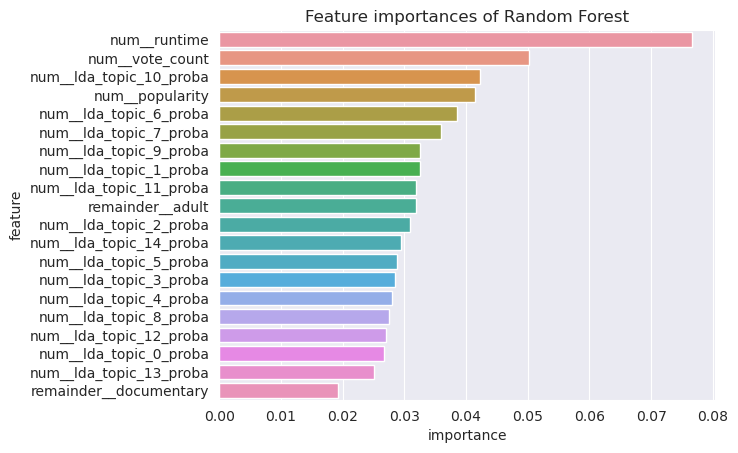

In [84]:
fig, ax = plt.subplots()
sns.barplot(data=df_importances, x="importance", y="feature", ax=ax)
ax.set_title("Feature importances of Random Forest");

### Lasso

In [85]:
feaure_names = lasso.named_steps["preprocessor"].get_feature_names_out()
importances = np.abs(lasso.named_steps["model"].coef_)
df_importances = pd.DataFrame({"feature": feaure_names, "absolute value of coef": importances})
df_importances = df_importances.sort_values(by="absolute value of coef", ascending=False)[:20]

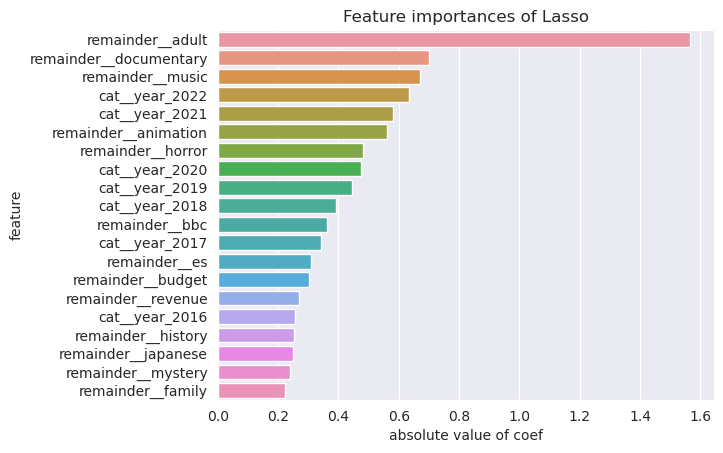

In [86]:
fig, ax = plt.subplots()
sns.barplot(data=df_importances, x="absolute value of coef", y="feature", ax=ax)
ax.set_title("Feature importances of Lasso");